# Surprise House - Price Prediction Assignment

#### Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. 

Considering the data provided by the company in the 'train.csv' file, they want to know —


- Which variables are significant in predicting the price of a house, and

- How well those variables describe the price of a house.

#### Business Goal:

We are required to model the price of houses with the available independent variables in the dataset. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

This notebook is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation

### 1. Data Understanding and Exploration

Let's first import the required libraries and have a look at the dataset and understand the size, attribute names etc.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [2]:
# to ignore any warnings that may be thrown 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading the dataset
house = pd.read_csv("train.csv", na_values="NAN")

In [4]:
# Let's take a look at the first few rows
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Auto EDA to understand the nature, distribution of different variables
import sweetviz as sv
sweet_report = sv.analyze(house,pairwise_analysis="off")
sweet_report.show_html('sweet_report.html')

                                             |      | [  0%]   00:00 -> (? left)

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Some notoable findings from the above execution:

- In total there are 1460 entries
- For some of the variables like 'Ally', 'PoolQC', 'Fence' etc, the percentage of missing values are quite huge (1369/1460). Clearly we can't simply impute these values as then we will loose a considerable amount of data for our analysis
- The Sales Price variable, which is the variable of interest is rightly skewed. We will have to do the treatment for the same for subsequent analysis

In [6]:
# to get an understanding of the data types and non null count of various columns
print(house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# Summary of the dataset : 1460 rows, 81 columns

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

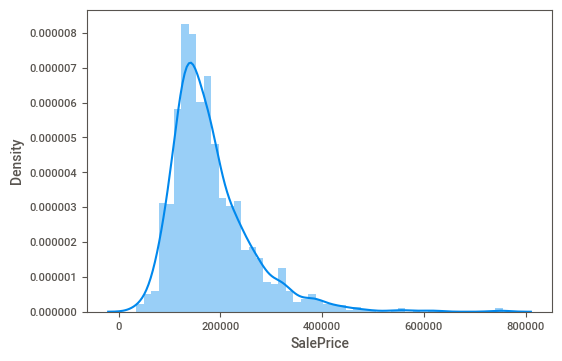

In [8]:
# Plotting the distribution lot for SalesPrice to understand its distribution. We notice that it is rightly skewed
sns.distplot(house['SalePrice'])

In [9]:
# Same lack of symmetry in the variable's distribution is indicated by its skewness and kurtosis values
print("Skewness: %f" % house['SalePrice'].skew())
print("Kurtosis: %f" % house['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


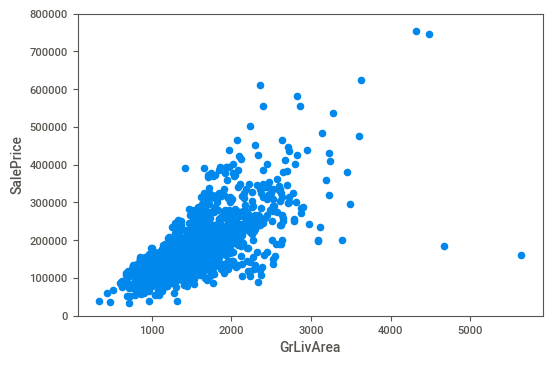

In [10]:
#Plotting a scatter plot between above ground living area & Salesprice.
var = 'GrLivArea'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

We notice that there seems to be a positive correlation between these two variables. Moreover, the houses with very high area and sales price are less in number

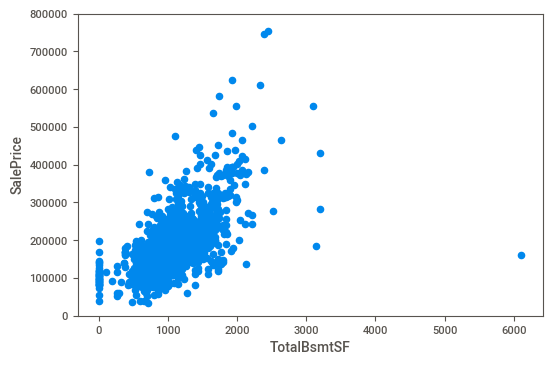

In [11]:
# Plotting a scatter plot between Total Basement Area & Salesprice.
var = 'TotalBsmtSF'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

We notice roughly similar kind of trend as observed between Sales price and housing area

<AxesSubplot:xlabel='SalePrice'>

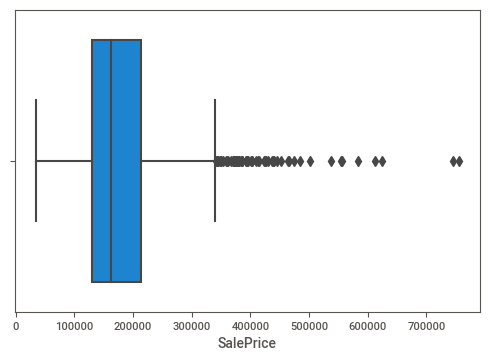

In [12]:
# plotting boxplot for SalePrice variable
sns.boxplot(data['SalePrice'])

It is observed that the median value of SalePrice lies somewhere around 150000. Moreover, it is also seen that houses with very high price like >500000 are few. Majority of the sale price vary are within the 35-40,0000 limit.

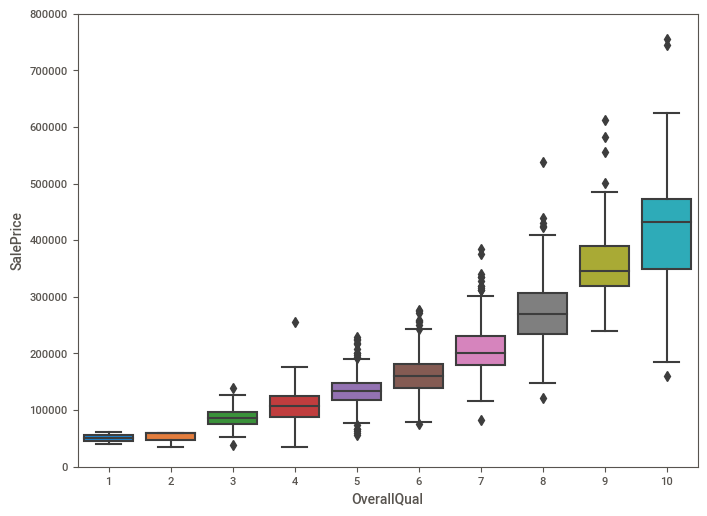

In [13]:
#Plotting a bi-variate box plot between SalePrice and Overall Material & finish of the house
var = 'OverallQual'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

It is noticed that as the quality of Overall material and finish of the house increases, the sale price of the property increases, which is intutively right.

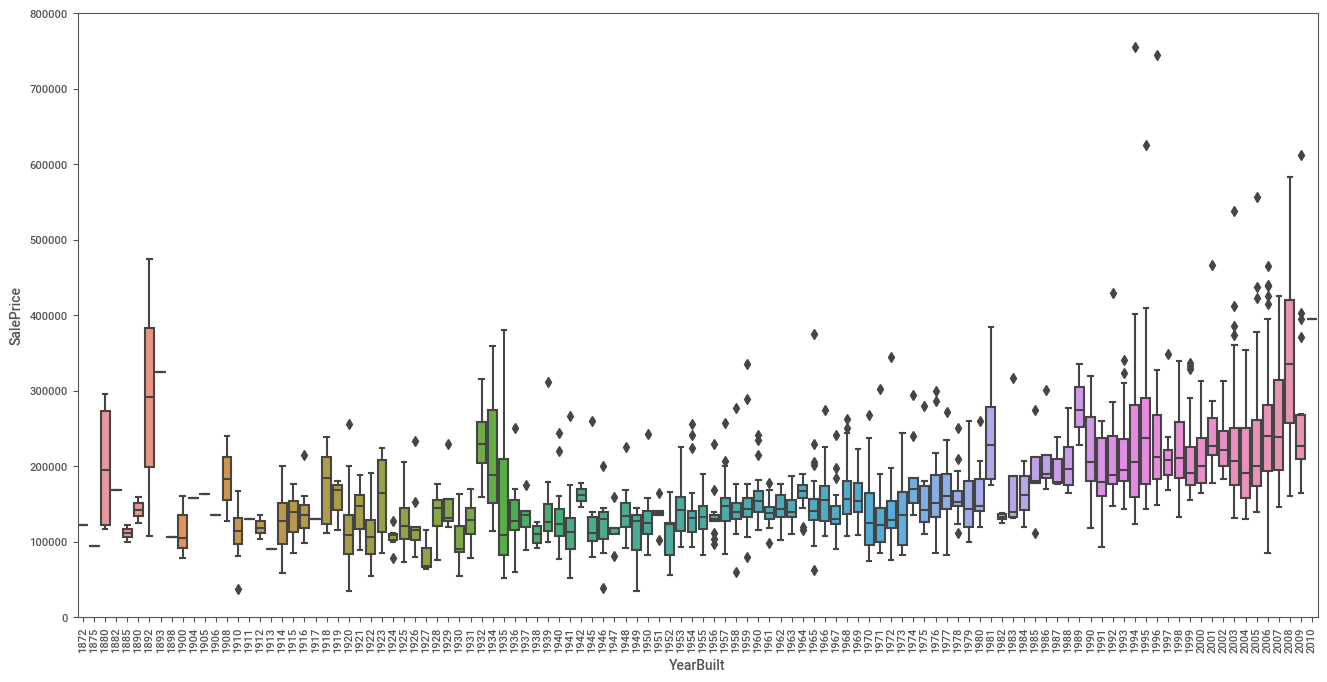

In [14]:
#Plotting a boxplot between the sale price of the house and the year it was built to check on the existence of any trends

var = 'YearBuilt'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

From the above plot, it can't be concluded that the SalePrice is increasing over the years. Though we do notice slight increase in the median value of sales price over the years. Moreover, we do notice that the spread of the sale price over the years has also increased significantly.

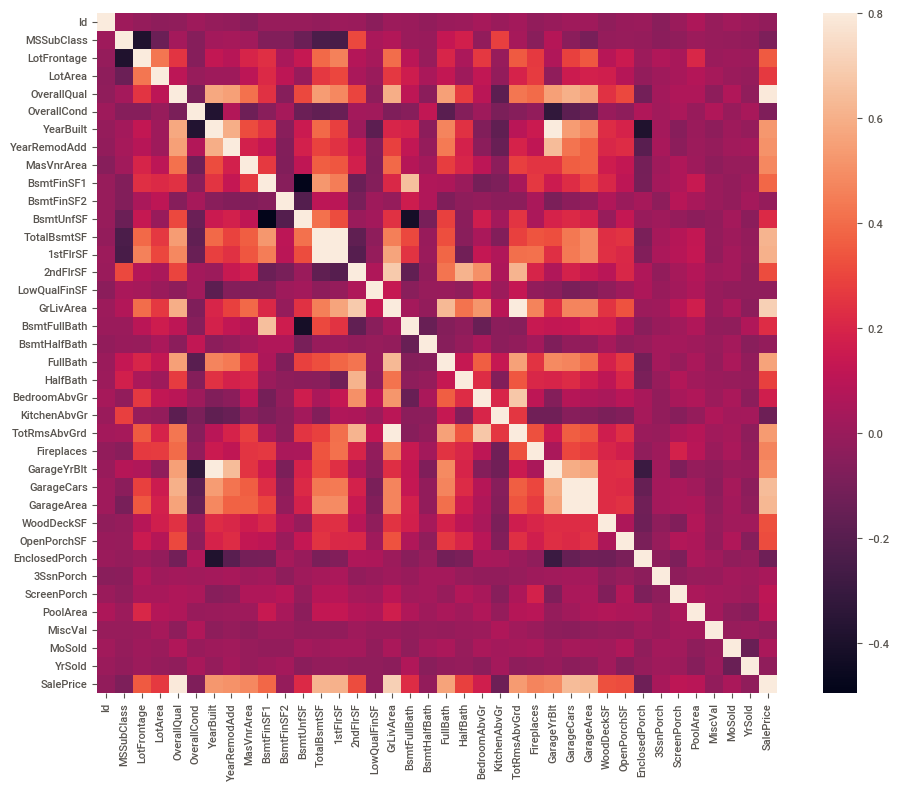

In [15]:
# plotting the correlation matrix for each of the variables.
corrmat = house.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

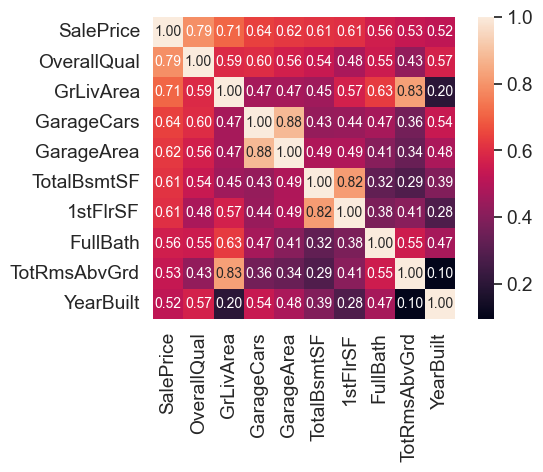

In [16]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index #to get the first 10 high correlations with salesprice in descending order
cm = np.corrcoef(house[cols].values.T) # creating the correlation matrix with coeficients
sns.set(font_scale=1.25)
#plotting the heatmap 
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Strong positive correlation is observed between the following variables and Sale price of the house:

- overall quality
- living Area
- Garage Area
- Garage Size
- Total Square Feet of Basement Area

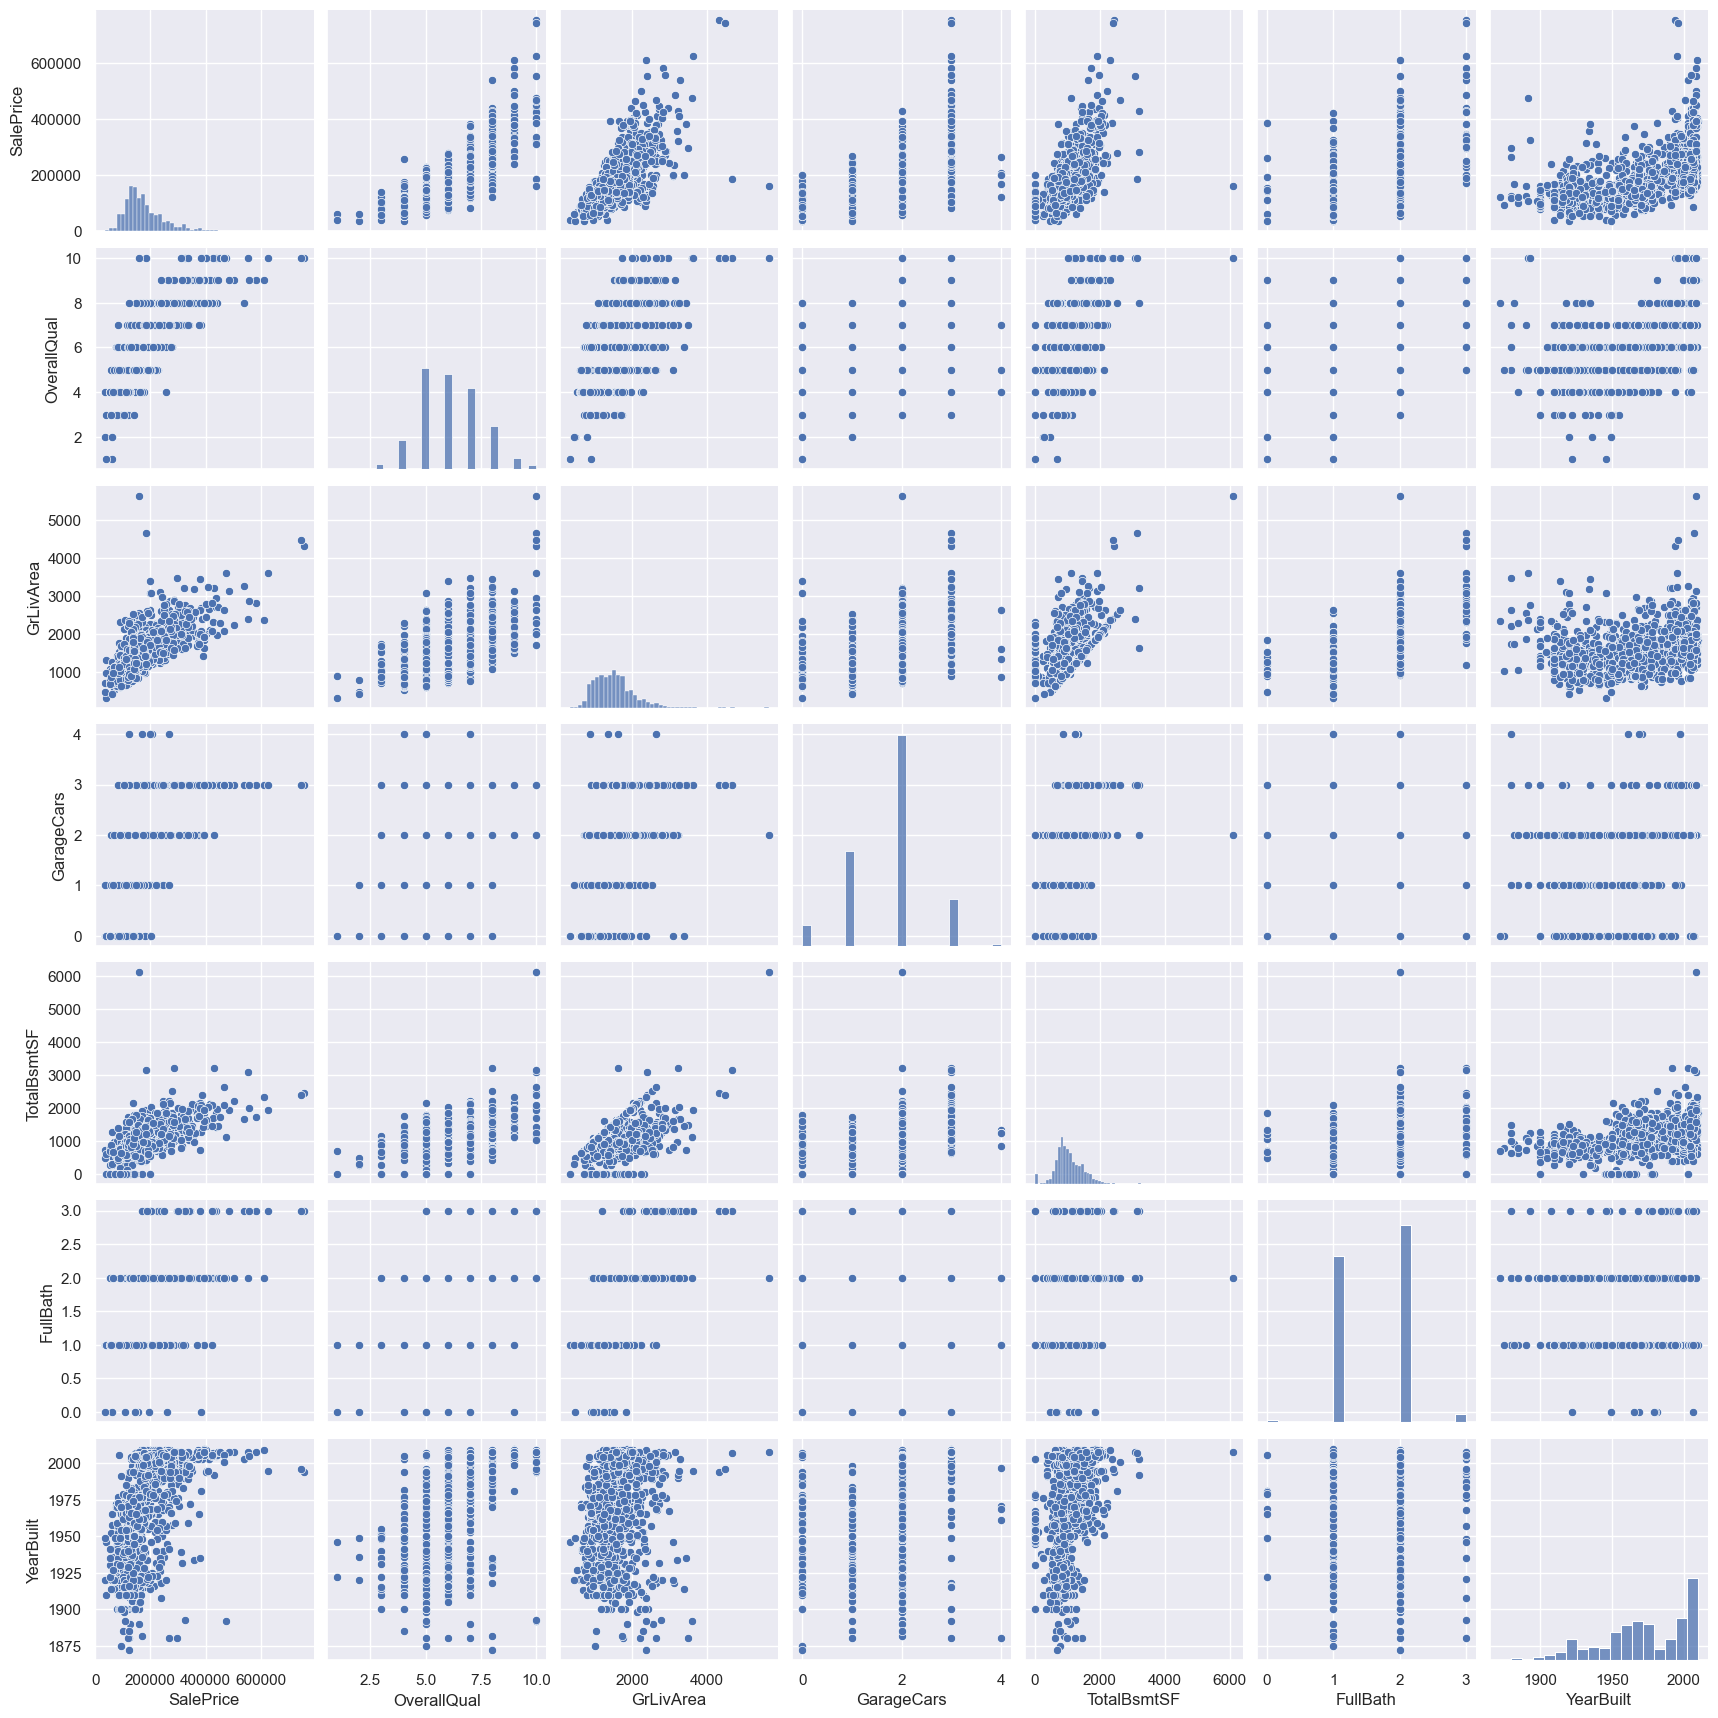

In [17]:
#plotting pairplot between the variables for which strong correlation was observed
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house[cols], size = 2.5)
plt.show();

# Missing data Treatment


In [18]:
#getting the total sum of null values for different variables
total = house.isnull().sum().sort_values(ascending=False)

# getting the percentage values for those missing variables
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)

#creating a dataframe for the same holding total and percentage values
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


With data this large, it is not surprising that there are a lot of missing values in the cells. In order to effectively train our model we build, we must first deal with the missing values. There are missing values for both numerical and categorical data. We will see how to deal with both.


If we look at the data description file provided, we notice that for some categories such as 'Alley', NaN actually means something. This means that if a value is NaN, the house might not have that certain attribute, which will affect the price of the house. Therefore, it is better to not drop, but fill in the null cell with a value called "None" which serves as its own category.

In [19]:
#after reffering the data dictionary, collating the list of columns for which NAN has some meaning

null_has_meaning = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

In [20]:
#Replacing the NAN's with None to indicate the actual meaning of those features
for i in null_has_meaning:
    house[i].fillna("None", inplace=True)
    house[i].fillna("None", inplace=True)

In [21]:
#checking the state of null values after above operation
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

From the above, it is now noticed that most of the NAN's that actually had a meaning are interpreted correctly now.

## Imputing the "Real" NaN Values

These are the real NaN values that we have to deal with accordingly because they were not recorded.

In [22]:
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy="median") # for imputing the missing values with median value

In [23]:
#get the sum of remaining NANs that are real and should be dealt with
total = house.isnull().sum().sort_values(ascending=False)

# getting the percentage of those NANs
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
# creating the data frame with the total and percentage values of those NANs
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
KitchenQual,0,0.000000


LotFrontage has too many Null values and it is a numerical value so it may be better to just drop it.

In [24]:
# dropping the missing values in lot frontage
house.drop("LotFrontage", axis=1, inplace=True)

In [25]:
#repeating those some steps to check on the total & percentage of missing values
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
KitchenQual,0,0.000000


GarageYrBlt, MasVnrArea, and MasVnrType all have a fairly decent amount of missing values. MasVnrType is categorical so we can replace the missing values with "None", as we did before. We can fill the others with median.

In [26]:
#replacing the missing values in the first two variables with Median value
house["GarageYrBlt"].fillna(house["GarageYrBlt"].median(), inplace=True)
house["MasVnrArea"].fillna(house["MasVnrArea"].median(), inplace=True)
#replacing the missing values in the categorical variable with none
house["MasVnrType"].fillna("None", inplace=True)

In [27]:
#checking for missing data and percentage again after above operations
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Electrical,1,0.000685
MSSubClass,0,0.000000
GarageYrBlt,0,0.000000
GarageType,0,0.000000
FireplaceQu,0,0.000000


Now that only one row has a null entry, we will drop the row.

In [28]:
house.dropna(inplace=True)

In [29]:
#checking for missing data and percentage again after above operations
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Id,0,0.0
MSSubClass,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0


Now there are no missing values present. Checking the same below

In [30]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

### Now we will determine the data type of all features remaining

In [31]:
types_train = house.dtypes #type of each feature in data: int, float, object
num_train = types_train[(types_train == 'int64') | (types_train == float)] #numerical values are either type int or float
cat_train = types_train[types_train == object] #categorical values are type object

In [32]:
pd.DataFrame(types_train).reset_index().set_index(0).reset_index()[0].value_counts()

object     43
int64      35
float64     2
Name: 0, dtype: int64

In [33]:
#we should convert num_train to a list to make it easier to work with later on
numerical_values_train = list(num_train.index)

In [34]:
# printing the list of numerical features in the dataset
print(numerical_values_train)

['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


These are all the numerical features in our data.

In [35]:
categorical_values_train = list(cat_train.index)
# printing the list of categorical features in the dataset
print(categorical_values_train)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


These are all the caregorical features in our data.

# Data Preparation

Ok, now that we have dealt with all the missing values, it looks like it's time for some feature engineering, the second part of our data preprocessing. We need to create feature vectors in order to get the data ready to be fed into our model as training data. This requires us to convert the categorical values into representative numbers through One Hot Encoding.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

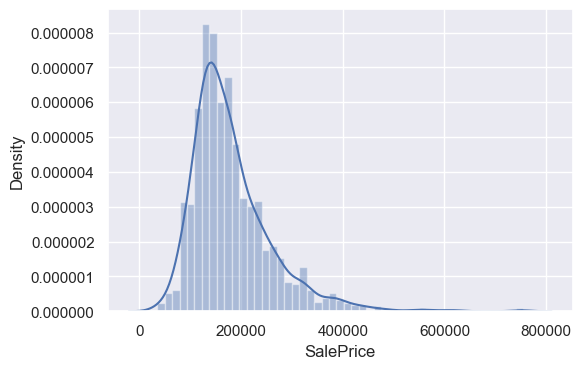

In [36]:
# plotting a distribution plot for salesprice
sns.distplot(house["SalePrice"])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

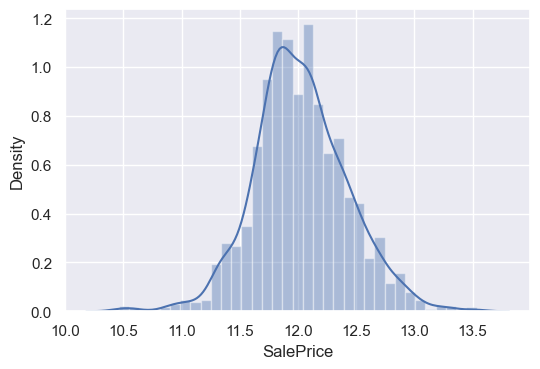

In [37]:
#doing data transformation for better viewing of the distribution
sns.distplot(np.log(house["SalePrice"]))

It appears that the target, SalePrice, is very skewed and a transformation like a logarithm would make it more normally distributed. Machine Learning models tend to work much better with normally distributed targets, rather than greatly skewed targets. By transforming the prices, we can boost model performance.

In [38]:
# As observed above, doing the required data transformation
house["TransformedPrice"] = np.log(house["SalePrice"])

In [39]:
# printing the list of categorical features in the dataset
print(categorical_values_train)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [40]:
# performing the encoding of the categorical features in the data set for model building later on
for i in categorical_values_train:
    feature_set = set(house[i])
    for j in feature_set:
        feature_list = list(feature_set)
        house.loc[house[i] == j, i] = feature_list.index(j)

In [41]:
house.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TransformedPrice
0,1,60,3,8450,0,0,0,3,1,2,...,0,1,0,0,2,2008,0,3,208500,12.247694
1,2,20,3,9600,0,0,0,3,1,4,...,0,1,0,0,5,2007,0,3,181500,12.109011
2,3,60,3,11250,0,0,1,3,1,2,...,0,1,0,0,9,2008,0,3,223500,12.317167
3,4,70,3,9550,0,0,1,3,1,1,...,0,1,0,0,2,2006,0,4,140000,11.849398
4,5,60,3,14260,0,0,1,3,1,4,...,0,1,0,0,12,2008,0,3,250000,12.429216


Great! It seems like we have changed all the categorical strings into a representative number. We are ready to build our models!

# Model Building

Now that we've preprocessed and explored our data, we have a much better understanding of the type of data that we're dealing with. Now, we can began to build and test different models for regression to predict the Sale Price of each house.

In [42]:
X = house.drop(["Id", "SalePrice", "TransformedPrice"], axis=1).values# dropping the variables which wont be useful for model building 
y = house["TransformedPrice"].values # segregating the target variable

In [43]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [44]:
X_Feature_Names = house.drop(["Id", "SalePrice", "TransformedPrice"], axis=1)
X_Feature_Names.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Ope

In [45]:
#checking the r2 scores with an Unregularized Model to assess its performance
from sklearn.linear_model import LinearRegression,Lasso, Ridge
lr = LinearRegression()
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.9080637831245871
Testing R2
0.15832650010654836


Clearly we notice that there is a huge drop in the training and testing r2 scores, inidcating that the model has clearly overfitted if regularization is not applied

In [46]:
#If alpha=0 then overfitting [Unregularised Model], as noticed above
#Higher the alpha more the regularization more the underfitting
#Lower the alpha lesser the regularization more the overfitting
lr = Lasso(alpha=0.002) # instantiation of Lasso regression object
lr.fit(X_train,y_train) # fitting the lasso regression on the training set for regularization
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.880982664783023
Testing R2
0.8338104163186548


After applying regularization, we notice that the the difference between the train and test r2 scores has reduced, indicating that with regularization the problem of overfitting has been dealt with properly.

In [47]:
#checking the coefficients of the features after fitting the model
lr.coef_

array([-5.92998200e-04, -9.42660024e-03,  2.16298181e-06, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -6.81714842e-03,  0.00000000e+00,  1.07293708e-03, -1.03214561e-02,
        0.00000000e+00, -5.62058596e-03,  6.23077443e-03,  7.53212303e-02,
        4.71368874e-02,  2.75998641e-03,  1.20922648e-03, -6.72216192e-04,
       -2.00566005e-02,  3.59537270e-04, -1.00230325e-04,  0.00000000e+00,
       -6.38784806e-06,  5.07470192e-03, -0.00000000e+00,  1.88441256e-02,
       -7.95399446e-03,  5.43032913e-03, -0.00000000e+00,  9.56580585e-03,
        7.90290337e-05, -9.78747586e-04,  5.39143999e-05,  5.09827342e-05,
        2.93426587e-05,  0.00000000e+00, -8.09646460e-03,  3.47729578e-02,
       -6.23610946e-04,  1.72090757e-04,  2.18660902e-04,  2.18228407e-04,
        2.86029555e-05,  4.52985809e-02,  0.00000000e+00,  2.25362237e-02,
        7.58383971e-03,  0.00000000e+00, -0.00000000e+00, -5.55245874e-03,
        4.88478219e-03, -

In [48]:
# collating a list of alpha's for hyperparameter tuning to get the best model fit
params = {'alpha': [0.00000001,0.0000001,0.000001,0.00001,0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

In [49]:
# Importing the relevant libraries
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [50]:
# Applying Lasso
lasso = Lasso()

# applying K Fold cross validation with 5 folds for training the model appropriately
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0,
                                   7.0, 8.0, 9.0, 10.0, 20, 50, 100, ...]},
             return_train_score=True, scoring='r2', verbose=1)

In [51]:
# Checking the results from the K-Fold cross validation performed
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.021947,0.009163,0.000864,0.000094,0.0,{'alpha': 1e-08},0.923154,0.896795,0.800615,0.793369,...,0.860021,0.052903,1,0.901244,0.907450,0.930641,0.907680,0.906376,0.910678,0.010251
1,0.018602,0.010406,0.000806,0.000024,0.0,{'alpha': 1e-07},0.923155,0.896794,0.800615,0.790543,...,0.859457,0.053622,2,0.901244,0.907450,0.930641,0.907680,0.906376,0.910678,0.010251
2,0.018275,0.010912,0.001025,0.000507,0.000001,{'alpha': 1e-06},0.923166,0.896788,0.800616,0.760162,...,0.853384,0.062136,3,0.901244,0.907450,0.930641,0.907676,0.906376,0.910677,0.010251
3,0.010082,0.001478,0.000770,0.000003,0.00001,{'alpha': 1e-05},0.923269,0.896723,0.800622,0.642661,...,0.829917,0.102255,4,0.901242,0.907448,0.930639,0.907655,0.906374,0.910672,0.010252
4,0.009003,0.000615,0.001034,0.000522,0.0001,{'alpha': 0.0001},0.923766,0.895965,0.800605,0.641699,...,0.829897,0.102728,5,0.901035,0.907275,0.930464,0.907564,0.906264,0.910520,0.010248


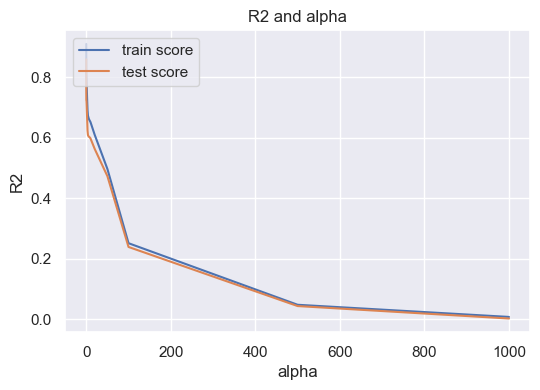

In [52]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2')

plt.title("R2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [53]:
alpha = 50

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=50)

In [54]:
# with alpha =50, we notice that almost all the coefficients are becoming zero. Hence, it wont be the right choice of alpha
lasso.coef_

array([-0.00000000e+00, -0.00000000e+00,  4.02426915e-06, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        1.41724335e-04, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        2.68173575e-04,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

From the above, it is noticed that for Lasso Regression, the alpha value of 0.002 is giving better R2 scores for both training and test data sets

In [55]:
alpha = 0.002
lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.002)

In [56]:
lasso.coef_

array([-5.92998200e-04, -9.42660024e-03,  2.16298181e-06, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -6.81714842e-03,  0.00000000e+00,  1.07293708e-03, -1.03214561e-02,
        0.00000000e+00, -5.62058596e-03,  6.23077443e-03,  7.53212303e-02,
        4.71368874e-02,  2.75998641e-03,  1.20922648e-03, -6.72216192e-04,
       -2.00566005e-02,  3.59537270e-04, -1.00230325e-04,  0.00000000e+00,
       -6.38784806e-06,  5.07470192e-03, -0.00000000e+00,  1.88441256e-02,
       -7.95399446e-03,  5.43032913e-03, -0.00000000e+00,  9.56580585e-03,
        7.90290337e-05, -9.78747586e-04,  5.39143999e-05,  5.09827342e-05,
        2.93426587e-05,  0.00000000e+00, -8.09646460e-03,  3.47729578e-02,
       -6.23610946e-04,  1.72090757e-04,  2.18660902e-04,  2.18228407e-04,
        2.86029555e-05,  4.52985809e-02,  0.00000000e+00,  2.25362237e-02,
        7.58383971e-03,  0.00000000e+00, -0.00000000e+00, -5.55245874e-03,
        4.88478219e-03, -

In [57]:
# Mapping the coeficients values with feature variables to understand the significance for each coeff
coef_dict = dict(zip(X_Feature_Names.columns, lasso.coef_))

In [58]:
#sorting the dictinary in ascending order by its values
coef_dict
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}

{'RoofMatl': -0.020056600515520703,
 'SaleCondition': -0.010675461481598533,
 'Condition1': -0.010321456095067886,
 'MSZoning': -0.009426600236561283,
 'HeatingQC': -0.008096464595555498,
 'BsmtQual': -0.00795399445548905,
 'YrSold': -0.006959803348137788,
 'LotConfig': -0.006817148422776284,
 'GarageQual': -0.006814923006433575,
 'MiscFeature': -0.0067951154932871915,
 'BldgType': -0.005620585957383082,
 'KitchenQual': -0.005552458744056897,
 'Functional': -0.0049857538881788715,
 'PoolArea': -0.0013747916620839207,
 'BsmtFinType2': -0.0009787475859837742,
 'MoSold': -0.0007178036024634583,
 'RoofStyle': -0.0006722161920969884,
 'Electrical': -0.0006236109456766545,
 'MSSubClass': -0.0005929981995472518,
 'GarageYrBlt': -0.0005761875118243384,
 'Exterior2nd': -0.00010023032529364389,
 'OpenPorchSF': -9.583918485297555e-05,
 'MasVnrArea': -6.387848061279038e-06,
 'MiscVal': -3.739539513450219e-06,
 'Street': -0.0,
 'Alley': 0.0,
 'LotShape': 0.0,
 'LandContour': 0.0,
 'Utilities': 0.0,

From the above results with Lasso regression, we see that the following variables have a significant impact in the sales price of the house and are directly proportional to it:

- Overall Quality of the material and finish of the house
- Basement full Bathrooms
- Size of Garage in Car capacity
- Overall Condition of the house
- Number of Fireplaces


In [59]:
# Applying Ridge regression
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0,
                                   7.0, 8.0, 9.0, 10.0, 20, 50, 100, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [60]:
#plotting the results for cross validation
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017211,0.011065,0.001593,0.000672,0.0,{'alpha': 1e-08},-0.086994,-0.093493,-0.102601,-0.094084,...,-0.093992,0.004996,1,-0.086019,-0.082222,-0.075677,-0.083316,-0.082988,-0.082044,0.003432
1,0.003586,0.000155,0.000903,0.000274,0.0,{'alpha': 1e-07},-0.086994,-0.093493,-0.102601,-0.094084,...,-0.093992,0.004996,2,-0.086019,-0.082222,-0.075677,-0.083316,-0.082988,-0.082044,0.003432
2,0.003477,0.000011,0.000763,0.000010,0.000001,{'alpha': 1e-06},-0.086994,-0.093493,-0.102601,-0.094087,...,-0.093993,0.004996,3,-0.086019,-0.082222,-0.075677,-0.083316,-0.082988,-0.082044,0.003432
3,0.003524,0.000075,0.000777,0.000022,0.00001,{'alpha': 1e-05},-0.086994,-0.093493,-0.102601,-0.094109,...,-0.093997,0.004996,4,-0.086019,-0.082222,-0.075677,-0.083317,-0.082988,-0.082045,0.003432
4,0.003462,0.000109,0.000996,0.000494,0.0001,{'alpha': 0.0001},-0.086993,-0.093493,-0.102602,-0.094326,...,-0.094041,0.004998,5,-0.086020,-0.082223,-0.075677,-0.083318,-0.082989,-0.082046,0.003432


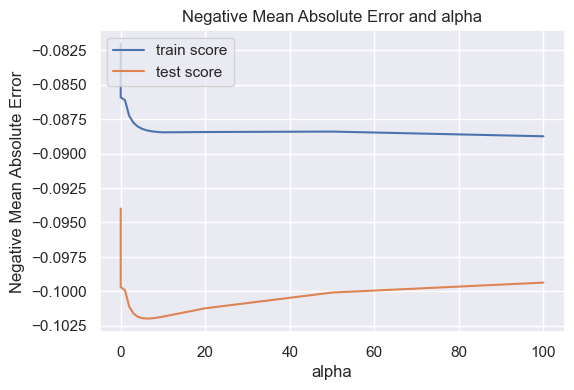

In [61]:
# plotting mean test and train scores with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [62]:
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-4.46199332e-04, -1.50421552e-02,  2.41020862e-06, -4.18812189e-02,
        5.92147251e-03, -1.35397625e-03,  5.83928237e-03,  1.29567210e-02,
       -1.14206860e-02,  4.14599571e-02,  9.14788827e-04, -1.08698864e-02,
        1.90590185e-02, -1.13570849e-02,  8.82189573e-03,  7.25004281e-02,
        4.86401350e-02,  2.28964694e-03,  1.02886449e-03, -2.93813404e-03,
       -4.21572338e-02,  1.13656705e-03, -7.72299905e-04, -6.13817792e-05,
       -1.01860021e-06,  1.76794789e-02, -5.37514858e-03,  2.36902901e-02,
       -1.69742202e-02,  1.92442822e-02, -2.87352504e-03,  1.01783047e-02,
        3.16766201e-05, -4.57137471e-03,  2.05175949e-05,  1.90825309e-05,
        7.12767473e-05,  4.29444341e-03, -1.16486235e-02,  6.78381727e-02,
       -1.62002468e-03,  3.30729644e-05,  7.09985724e-05,  3.47559303e-05,
        1.38827447e-04,  6.07000902e-02,  1.72506221e-02,  4.85894658e-02,
        3.43461624e-02, -3.03124429e-04, -1.00899489e-02, -1.40691535e-02,
        8.29378708e-03, -

In [63]:
print("Training R2")
print(ridge.score(X_train,y_train))
print("Testing R2")
print(ridge.score(X_test,y_test))

Training R2
0.888776987222262
Testing R2
0.8278828261629648


For ridge regression, the alpha value of 10 is giving good results.

In [64]:
# Mapping the coeficients values with feature variables to understand the significance for each coeff
coef_dict = dict(zip(X_Feature_Names.columns, ridge.coef_))

In [65]:
#sorting the dictinary in ascending order by its values
coef_dict
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}

{'PoolQC': -0.1439832547976037,
 'RoofMatl': -0.042157233808866865,
 'Street': -0.04188121893199827,
 'GarageQual': -0.01717142681285283,
 'BsmtQual': -0.01697422015558455,
 'MSZoning': -0.015042155247991653,
 'SaleCondition': -0.014901691401370494,
 'KitchenQual': -0.014069153519485964,
 'MiscFeature': -0.013652890164784314,
 'HeatingQC': -0.011648623516176026,
 'LotConfig': -0.011420685972440107,
 'BldgType': -0.0113570849255231,
 'Condition1': -0.010869886429668482,
 'Functional': -0.010301234297036766,
 'KitchenAbvGr': -0.010089948876218717,
 'YrSold': -0.007283746625485381,
 'Fence': -0.0072125724363069806,
 'ExterCond': -0.005375148579959233,
 'BsmtFinType2': -0.004571374711558772,
 'RoofStyle': -0.0029381340427725743,
 'BsmtExposure': -0.0028735250377822583,
 'Electrical': -0.0016200246771509402,
 'LotShape': -0.0013539762490950699,
 'MoSold': -0.0010137782385373584,
 'PoolArea': -0.0009064980775897896,
 'Exterior2nd': -0.0007722999052996063,
 'GarageYrBlt': -0.00071922100835503

From the above results with ridge regression, we see that the following variables have a significant impact in the sales price of the house and are directly proportional to it:

- Overall Quality of the material and finish of the house
- Basement full Bathrooms
- Size of Garage in Car capacity
- Overall Condition of the house
- Central Air conditioning
- type of road access to street

## Conclusion

The above analysis can be used by the management to understand how exactly the prices vary with the different variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, these models will help them to understand the pricing dynamics of a new market.

Considering that 5 significant variables are not available in the incoming data and accordingly re-building the Lasso model.